<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/6-deep-learning-for-text-and-sequences/6_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence processing with convnets

You learned about convolutional neural networks (convnets) and how they perform particularly well on computer vision problems, due to their ability to operate convolutionally, extracting features from local input patches and allowing for
representation modularity and data efficiency. The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing. Time can be treated as a spatial dimension, like the height or width of a 2D image.

Such 1D convnets can be competitive with RNNs on certain sequence-processing
problems, usually at a considerably cheaper computational cost. Recently, 1D convnets, typically used with dilated kernels, have been used with great success for audio generation and machine translation. In addition to these specific successes, it has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

**Understanding 1D convolution for sequence data**

The convolution layers introduced previously were 2D convolutions, extracting 2D
patches from image tensors and applying an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/1D-convolution.png?raw=1' width='800'/>

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). 

For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

**1D pooling for sequence data**

You’re already familiar with 2D pooling operations, such as 2D average pooling and max pooling, used in convnets to spatially downsample image tensors. The 2D pooling operation has a 1D equivalent: extracting 1D patches (subsequences) from an input and outputting the maximum value (max pooling) or average value (average pooling). Just as with 2D convnets, this is used for reducing the length of 1D inputs (subsampling).


## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Embedding, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Implementing a 1D convnet

n Keras, you would use a 1D convnet via the Conv1D layer, which has a very similar interface to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [2]:
max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [0]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))

model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

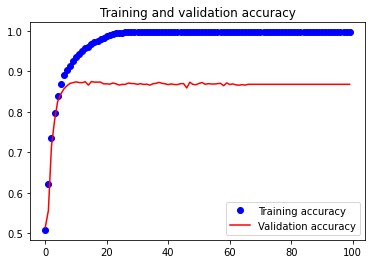

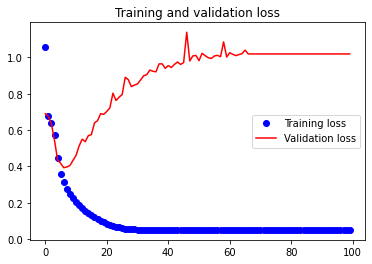

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences